#### Intro

Using precomputed VGG features and adding a fully conv net on top of that. 
Inlcuding dropout to avoid overfitting. 

Validation: visually checking results.
No augmentation 


Improvements:
add augmentation for training and mask data 
fine-tune top layers of vgg

In [1]:
%matplotlib inline
import utils#; reload(utils)
from utils import *
from __future__ import division, print_function


import os
import random

import numpy as np
import matplotlib.pyplot as plt

from glob import iglob, glob

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array

from scipy.misc import imresize, toimage
import ujson as json
import cv2

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data/'
%matplotlib inline



WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
DATA_HOME_DIR
path = DATA_HOME_DIR+"fishnofish/"
batch_size=16

In [3]:
anno_classes = ["Fish"]#['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']


### Loading data

In [4]:
# trn = get_data(path+'train', (360,640))
# val = get_data(path+'valid', (360,640))
# test = get_data(path+'test', (360,640))

In [5]:
#non_processed: 'results/test_640.dat'

# save_array(DATA_HOME_DIR+"fishnofish/results/trn_640_processed_1.5.dat", trn)
# save_array(DATA_HOME_DIR+"fishnofish/results/val_640_processed_1.5.dat", val)
# save_array(DATA_HOME_DIR+"fishnofish/results/test_640_processed_1.5.dat", test)


In [4]:
#path = "data/fish/sample/"



(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

raw_val_filenames[0]

Found 3327 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 12153 images belonging to 1 classes.


'img_01570.jpg'

### Processing bounding boxes


In [7]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}/all_fish_labels.json'.format(DATA_HOME_DIR, c), 'r'))
    print ("Files with multiple bounding boxes: ")
    for  i , l in enumerate(j):
        if 'annotations' in l.keys() and len(l['annotations'])>0:
#             bb_json[l['filename'].split('/')[-1]] = sorted(
#                 l['annotations'], key=lambda x: x['height']*x['width'])[-1]
        #use all bounding boxes
            bb_json[l['filename'].split('/')[-1]] = l['annotations']
        if len(l['annotations']) > 1:
            print (l['filename'] , ", index: ", i, ", num bbox: ",len(l['annotations']) )

Files with multiple bounding boxes: 
img_07915.jpg , index:  1 , num bbox:  2
img_07892.jpg , index:  6 , num bbox:  2
img_07890.jpg , index:  7 , num bbox:  2
img_07879.jpg , index:  10 , num bbox:  3
img_07878.jpg , index:  11 , num bbox:  2
img_07876.jpg , index:  13 , num bbox:  2
img_07863.jpg , index:  18 , num bbox:  5
img_07858.jpg , index:  20 , num bbox:  3
img_07814.jpg , index:  26 , num bbox:  2
img_07801.jpg , index:  31 , num bbox:  2
img_07772.jpg , index:  37 , num bbox:  2
img_07767.jpg , index:  40 , num bbox:  2
img_07766.jpg , index:  41 , num bbox:  2
img_07749.jpg , index:  44 , num bbox:  2
img_07740.jpg , index:  47 , num bbox:  3
img_07739.jpg , index:  48 , num bbox:  2
img_07726.jpg , index:  53 , num bbox:  2
img_07720.jpg , index:  54 , num bbox:  4
img_07705.jpg , index:  57 , num bbox:  2
img_07686.jpg , index:  62 , num bbox:  4
img_07672.jpg , index:  65 , num bbox:  2
img_07657.jpg , index:  72 , num bbox:  3
img_07652.jpg , index:  73 , num bbox:  2


In [8]:
bb_json['img_01912.jpg']
# 

[{u'class': u'rect',
  u'height': 240.0,
  u'width': 179.0,
  u'x': 122.0,
  u'y': 298.0},
 {u'class': u'rect',
  u'height': 259.0,
  u'width': 358.0,
  u'x': 381.0,
  u'y': 308.0},
 {u'class': u'rect',
  u'height': 98.0,
  u'width': 306.0,
  u'x': 521.0,
  u'y': 171.0},
 {u'class': u'rect',
  u'height': 88.0,
  u'width': 366.0,
  u'x': 452.0,
  u'y': 83.0},
 {u'class': u'rect',
  u'height': 222.0,
  u'width': 85.0,
  u'x': 63.0,
  u'y': 162.0},
 {u'class': u'rect',
  u'height': 184.0,
  u'width': 129.0,
  u'x': 30.0,
  u'y': 137.0},
 {u'class': u'rect',
  u'height': 67.0,
  u'width': 147.0,
  u'x': 45.0,
  u'y': 131.0}]

In [9]:
# file2idx = {o:i for i,o in enumerate(raw_filenames)}
# val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [10]:
#For any images that have no annotations, we'll create an empty bounding box.

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
training_null_count = 0 
valid_null_count = 0 

for f in raw_filenames:
    if not f in bb_json.keys():
        print (f, " not found (training)")
        bb_json[f] = [empty_bbox]
        training_null_count += 1 
        
for f in raw_val_filenames:
    if not f in bb_json.keys(): 
        print (f, " not found (validation)")
        bb_json[f] = [empty_bbox]
        valid_null_count += 1
        
         

img_00576.jpg  not found (training)
img_07008.jpg  not found (training)
img_04798.jpg  not found (training)
img_02785.jpg  not found (training)
img_05444.jpg  not found (training)
img_01958.jpg  not found (training)
img_06460.jpg  not found (training)
img_06082.jpg  not found (training)
img_06773.jpg  not found (training)
img_04558.jpg  not found (training)
img_02292.jpg  not found (training)
img_03183.jpg  not found (training)
img_00568.jpg  not found (training)
img_06675.jpg  not found (training)
img_07100.jpg  not found (training)
img_01579.jpg  not found (training)
img_00616.jpg  not found (training)
img_04457.jpg  not found (training)
img_07584.jpg  not found (training)
img_05993.jpg  not found (training)
img_04395.jpg  not found (training)
img_04493.jpg  not found (training)
img_03765.jpg  not found (training)
img_02534.jpg  not found (training)
img_02716.jpg  not found (training)
img_02366.jpg  not found (training)
img_03332.jpg  not found (training)
img_05474.jpg  not found (tr

In [11]:
bb_json['img_00022.jpg']


[{'height': 0.0, 'width': 0.0, 'x': 0.0, 'y': 0.0}]

In [12]:
print (training_null_count, valid_null_count)

420 60


In [13]:
bb_params = ['height', 'width', 'x', 'y']

#bb: an array of boxes
def convert_bb(boxes, size, resized_width=640.,resized_height=360. ):
    
    output = []
#     print (boxes)

    for bb in boxes:
    
        bb = [bb[p] for p in bb_params]


            # conversion factors
        conv_x = (resized_width / size[0])
        conv_y = (resized_height / size[1])


        bb[0] = bb[0]*conv_y#+10
        bb[1] = bb[1]*conv_x#+10

    #     bb[2] = max((bb[2]*conv_x - 10), 0)
    #     bb[3] = max((bb[3]*conv_y - 10), 0)
        bb[2] = max((bb[2]*conv_x), 0)
        bb[3] = max((bb[3]*conv_y), 0)

#         print (bb)
        
        output.append(bb)


    return output
    

In [14]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]

# id2size = list(set(sizes))
# size2id = {o:i for i,o in enumerate(id2size)}
# val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [15]:
trn_bbox = [convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)]
val_bbox = [convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, raw_val_sizes)]

In [16]:
print (len(trn_bbox), len(val_bbox))

3327 450


In [17]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=1)

def show_bb(i):
    boxes  = val_bbox[i]
    plot(val[i])
    for bb in boxes:
        plt.gca().add_patch(create_rect(bb))

In [18]:
# show_bb(103)
#286 #18

### Create mask based on bounding box
this will serve as the prediction target

In [19]:
# bb_params = ['height', 'width', 'x', 'y']

def get_coordinates(bbox):
    height = bbox[0]
    width = bbox[1]
    
    #bottom left
    x0 = bbox[2] 
    y0 =  bbox[3]

    return [[x0,y0],[x0+width,y0],[x0+width,y0+height],[x0,y0+height]]


In [20]:
polygon_test = []

for box in val_bbox[103]:
    polygon_test.append(np.array(get_coordinates(box),np.int32))
# polygon_test

mask = np.zeros((360, 640), dtype="int32")
mask = cv2.fillPoly(mask, np.int32(polygon_test),255)


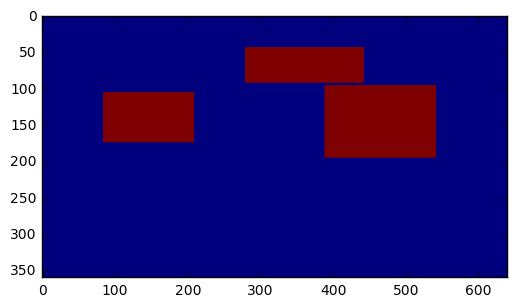

In [21]:
plt.imshow(mask)

Now that the sample is working, let's create our target patches in size 40x22

In [22]:
trn_bbox = [convert_bb(bb_json[f], s,resized_width=40,resized_height=22) for f,s in zip(raw_filenames, sizes)]
val_bbox = [convert_bb(bb_json[f], s,resized_width=40,resized_height=22) for f,s in zip(raw_val_filenames, raw_val_sizes)]

In [23]:
trn_targets = []
val_targets = [] 


#training bboxes
for i,b in enumerate(trn_bbox):
    
    #get individual fish bboxes
    mask_patches = []
    for box in trn_bbox[i]:
        mask_patches.append(np.array(get_coordinates(box),np.int32))    
    
    
    mask = np.zeros((22, 40), dtype="int32")
    
    mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
    trn_targets.append(mask)
    
    
#validation bboxes
for i,b in enumerate(val_bbox):
    
    mask_patches = []
    for box in val_bbox[i]:
        mask_patches.append(np.array(get_coordinates(box),np.int32))
        
        
    mask = np.zeros((22, 40), dtype="int32")
    mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
    val_targets.append(mask)    

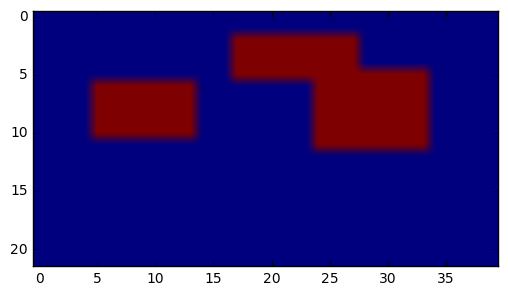

In [24]:
plt.imshow(val_targets[103])

In [25]:
np.array(trn_targets).shape

(3327, 22, 40)

### Get orientation annotations 


In [26]:
path

'/home/ubuntu/fish/data/fishnofish/'

In [27]:
orient_json = {}
for c in ["yft","shark","other","lag","dol","bet","alb"]:
    j = json.load(open('{}bb_annos/{}_labels.json'.format(path, c), 'r'))
    mj = json.load(open('{}mouthntail/{}_labels.json'.format(path,c), 'r'))
    print ("corresponding json file lengths: ",len(j),len(mj))

    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            
            filename = l['filename'].split('/')[-1]

#             bb_json[l['filename'].split('/')[-1]] = sorted(
#                 l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
            
            #find mounth and tail coordinates from the other json file
            orient_json[filename] = {}
            try:
                found_index = next(index for (index, d) in enumerate(mj) if d["filename"] == filename)
                orient_json[filename] =  mj[found_index]['annotations']
                
            except StopIteration:
                print (l['filename'], "not found in mount n tail")
                


corresponding json file lengths:  734 735
corresponding json file lengths:  176 177
corresponding json file lengths:  299 300
corresponding json file lengths:  67 68
corresponding json file lengths:  117 118
corresponding json file lengths:  200 201
corresponding json file lengths:  1719 1720


In [28]:
orient_json["img_05275.jpg"]

[{u'class': u'point', u'x': 913.6800000000027, u'y': 360.96000000000106},
 {u'class': u'point', u'x': 757.1700000000022, u'y': 404.6700000000012}]

In [29]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.,"mouthntail":[] }

In [30]:
for f in raw_filenames:
    if not f in orient_json.keys():
        print (f, " not found")
        orient_json[f] = [empty_bbox]
        
for f in raw_val_filenames:
    if not f in orient_json.keys(): 
        print (f, " not found")
        orient_json[f] = [empty_bbox]

img_00576.jpg  not found
img_07008.jpg  not found
img_04798.jpg  not found
img_02785.jpg  not found
img_05444.jpg  not found
img_01958.jpg  not found
img_06460.jpg  not found
img_06082.jpg  not found
img_06773.jpg  not found
img_04558.jpg  not found
img_02292.jpg  not found
img_03183.jpg  not found
img_00568.jpg  not found
img_06675.jpg  not found
img_07100.jpg  not found
img_01579.jpg  not found
img_00616.jpg  not found
img_04457.jpg  not found
img_07584.jpg  not found
img_05993.jpg  not found
img_04395.jpg  not found
img_04493.jpg  not found
img_03765.jpg  not found
img_02534.jpg  not found
img_02716.jpg  not found
img_02366.jpg  not found
img_03332.jpg  not found
img_05474.jpg  not found
img_05636.jpg  not found
img_00318.jpg  not found
img_00413.jpg  not found
img_03691.jpg  not found
img_01989.jpg  not found
img_04063.jpg  not found
img_04645.jpg  not found
img_00504.jpg  not found
img_05534.jpg  not found
img_01094.jpg  not found
img_06451.jpg  not found
img_07711.jpg  not found


In [31]:
def convert_bb_mouth_only(mt, size):
    
    bb = []    
    #adding mouth n tail ccordinates
    try:
        
        if len(mt) >1:
            bb.extend([mt[0]['x'],mt[0]['y'],mt[1]['x'],mt[1]['y']])
        else:
            bb.extend([0,0,0,0])
            return bb
    except IndexError:
        print ("empty mouth n tail")   

            
    
    
    # conversion factors
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])


    #mouth
    mx = bb[0]*conv_x
    my = bb[1]*conv_y

    #tail
    tx = bb[2]*conv_x
    ty = bb[3]*conv_y



    bb[0] = mx
    bb[1] = my
    bb[2] = tx
    bb[3] = ty  
    
    
    return bb


In [32]:
trn_orients = np.stack([convert_bb_mouth_only(orient_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_orients = np.stack([convert_bb_mouth_only(orient_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [33]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def create_point(pt, color='red'):
    return plt.Circle(pt,8, color=color,fill=True)


def show_bb(i):
    bb = val_orients[i]
    plot(val[i])

    plt.gca().add_patch(create_point((bb[0], bb[1])))
    plt.gca().add_patch(create_point((bb[2], bb[3]),"blue")) 

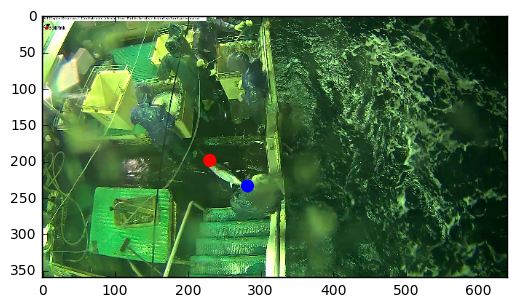

In [37]:
show_bb(100)

## Model Training

#### Loading data

In [35]:
# trn = load_array(DATA_HOME_DIR+"fishnofish/results/trn_640_processed_1.5.dat")
# val = load_array(DATA_HOME_DIR+"fishnofish/results/val_640_processed_1.5.dat")
# test = load_array(DATA_HOME_DIR+"fishnofish/results/test_640_processed_1.5.dat


#raw photos
test = load_array(path+"results/test_640.dat")
val = load_array(path+"results/val_640.dat")

Preprocessing conv features

In [47]:
#in case we need to precompute vgg features
# vgg640 = Vgg16BN((360, 640)).model
# vgg640.pop()
# vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

# conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)
# conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
# conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

# save_array(DATA_HOME_DIR+"fishnofish/results/conv_trn_640_processed_1.5.dat", conv_trn_feat)
# save_array(DATA_HOME_DIR+"fishnofish/results/conv_val_640_processed_1.5.dat", conv_val_feat)
# save_array(DATA_HOME_DIR+"fishnofish/results/conv_test_640_processed_1.5.dat", conv_test_feat)


450/450 [==============================] - 55s    


In [36]:
# conv_test_feat = load_array(DATA_HOME_DIR+"fishnofish/results/conv_test_640_processed_1.5.dat")
# conv_val_feat = load_array(DATA_HOME_DIR+"fishnofish/results/conv_val_640_processed_1.5.dat")

# #from raw files (no-preprocessing)
conv_trn_feat = load_array(path+"results/conv_trn_640.dat")
conv_val_feat = load_array(path+"results/conv_val_640.dat")
conv_test_feat = load_array(path+"results/conv_test_640.dat")



#### Defining Model

In [5]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
# print (vgg640.input_shape, vgg640.output_shape)
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=[ 'accuracy'])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [6]:
conv_layers,_ = split_at(vgg640, Convolution2D)

In [7]:
nf=128; p=0.6

inp = Input(conv_layers[-1].output_shape[1:])

# x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(inp)
x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)

x = Dropout(p/3)(x)

x =Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x =BatchNormalization(axis=1)(x)
x =Dropout(p/2)(x)


x =Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x =BatchNormalization(axis=1)(x)
x =Dropout(p/2)(x)

x =Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x =BatchNormalization(axis=1)(x)
x =Dropout(p)(x)
        

# the first output of the network: head and tail coordinates
x_orient = Flatten()(x)
x_orient = Dense(2048)(x_orient)
x_orient = BatchNormalization()(x_orient)
x_orient = Dropout(p/3)(x_orient)

x_orient = Dense(2048)(x_orient)
x_orient = BatchNormalization()(x_orient)
x_orient = Dropout(p/2)(x_orient)

x_orient = Dense(2048)(x_orient)
x_orient = BatchNormalization()(x_orient)
x_orient = Dropout(p)(x_orient)

x_orient = Dense(4, name='orientation')(x_orient)
        

    
# the second output of the network: heatmap   
x_hotzone = Convolution2D(1,3,3, border_mode='same', name='hotzone')(x)



In [8]:
# model = Sequential(get_lrg_layers())
model = Model([inp], [x_orient, x_hotzone])
model.compile(Adam(lr=0.001), loss=['mean_squared_error', 'mean_squared_error'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [43]:
# model.summary()

In [44]:
trn_targets = np.array(trn_targets)
val_targets = np.array(val_targets)

trn_reshaped = trn_targets.reshape(trn_targets.shape[0],1,trn_targets.shape[1],trn_targets.shape[2])
val_reshaped = val_targets.reshape(val_targets.shape[0],1,val_targets.shape[1],val_targets.shape[2])
# trn_targets.reshape(trn_targets.shape[0],1,trn_targets.shape[1],trn_targets.shape[2]).shape

In [45]:
model.fit(conv_trn_feat, [trn_orients, trn_reshaped], batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, [val_orients, val_reshaped]))

Train on 3327 samples, validate on 450 samples
Epoch 1/8
3327/3327 [==============================] - 76s - loss: 1733.6271 - orientation_loss: 51609.6570 - hotzone_loss: 1682.0175 - orientation_acc: 0.4139 - hotzone_acc: 0.0693 - val_loss: 1292.3419 - val_orientation_loss: 28853.0820 - val_hotzone_loss: 1263.4888 - val_orientation_acc: 0.4289 - val_hotzone_acc: 0.0545
Epoch 2/8
3327/3327 [==============================] - 76s - loss: 1034.6309 - orientation_loss: 20889.6046 - hotzone_loss: 1013.7412 - orientation_acc: 0.4983 - hotzone_acc: 0.0336 - val_loss: 1018.0428 - val_orientation_loss: 14626.4509 - val_hotzone_loss: 1003.4163 - val_orientation_acc: 0.4244 - val_hotzone_acc: 0.1017
Epoch 3/8
3327/3327 [==============================] - 76s - loss: 792.3475 - orientation_loss: 6926.7036 - hotzone_loss: 785.4207 - orientation_acc: 0.6435 - hotzone_acc: 0.0552 - val_loss: 905.7677 - val_orientation_loss: 7321.8806 - val_hotzone_loss: 898.4458 - val_orientation_acc: 0.7289 - val_hotz

In [253]:
# model.save_weights(path+"models/bboxdetector_lr3_good_visual_accuracy.hd5")
# model.save_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr3_1.5contrast_multibbox.hd5")
# model.load_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr3_1.5contrast_multibbox.hd5")

# model.save_weights(DATA_HOME_DIR+"fishnofish/models/bbox_and_orient_detector_1e3_8epch.h5")
# model.load_weights(DATA_HOME_DIR+"fishnofish/models/bbox_and_orient_detector_1e3_8epch.h5")


In [54]:
model.optimizer.lr = 1e-5
model.fit(conv_trn_feat, [trn_orients, trn_reshaped], batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, [val_orients, val_reshaped]))

Train on 3327 samples, validate on 450 samples
Epoch 1/5
3327/3327 [==============================] - 76s - loss: 362.9415 - orientation_loss: 4383.8698 - hotzone_loss: 358.5576 - orientation_acc: 0.7015 - hotzone_acc: 0.1025 - val_loss: 812.7888 - val_orientation_loss: 5711.5559 - val_hotzone_loss: 807.0772 - val_orientation_acc: 0.7022 - val_hotzone_acc: 0.0622
Epoch 2/5
3327/3327 [==============================] - 76s - loss: 320.2858 - orientation_loss: 4179.3621 - hotzone_loss: 316.1064 - orientation_acc: 0.6943 - hotzone_acc: 0.1007 - val_loss: 776.3254 - val_orientation_loss: 6395.3760 - val_hotzone_loss: 769.9300 - val_orientation_acc: 0.6778 - val_hotzone_acc: 0.1494
Epoch 3/5
3327/3327 [==============================] - 76s - loss: 281.7657 - orientation_loss: 3991.3857 - hotzone_loss: 277.7743 - orientation_acc: 0.6985 - hotzone_acc: 0.1042 - val_loss: 810.0913 - val_orientation_loss: 5401.8413 - val_hotzone_loss: 804.6894 - val_orientation_acc: 0.7467 - val_hotzone_acc: 0.1

In [9]:
# model.save_weights(DATA_HOME_DIR+"fishnofish/models/bbox_and_orient_detector_1e5_5epch_extra_layers.h5")
model.load_weights(DATA_HOME_DIR+"fishnofish/models/bbox_and_orient_detector_1e5_5epch_extra_layers.h5")

In [11]:
l = model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-1].output)

def get_cm(inp, label):
    conv = conv_fn([inp,0])[0, label] #conf_fn shape (1, 1, 22, 40)
    return scipy.misc.imresize(conv, (360,640), interp='nearest')


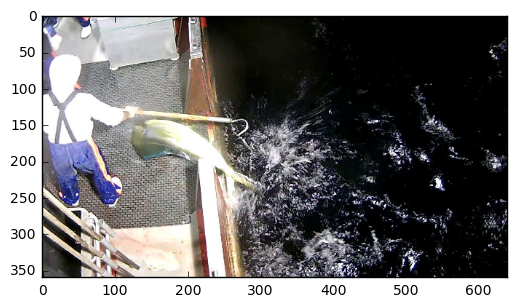

In [116]:
num_image = 117
#difficult: 124

plt.imshow(to_plot(val[num_image]))

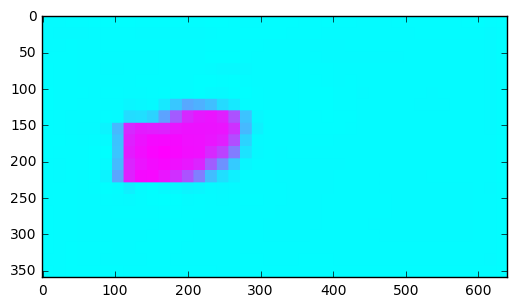

In [117]:
inp = np.expand_dims(conv_val_feat[num_image], 0)


cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

In [16]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def create_point(pt, color='red'):
    return plt.Circle(pt,8, color=color,fill=True)



def get_orients(inp):
    conv_fn = K.function([l[0].input, K.learning_phase()], l[-2].output)

    return(conv_fn([inp,0])[0])
    #[0, label] #conf_fn shape (1, 1, 22, 40)
    #     return scipy.misc.imresize(conv, (360,640), interp='nearest')


def show_bb(i):
    bb = get_orients(inp)
    plot(val[i])

    plt.gca().add_patch(create_point((bb[0], bb[1])))
    plt.gca().add_patch(create_point((bb[2], bb[3]),"blue"))
  

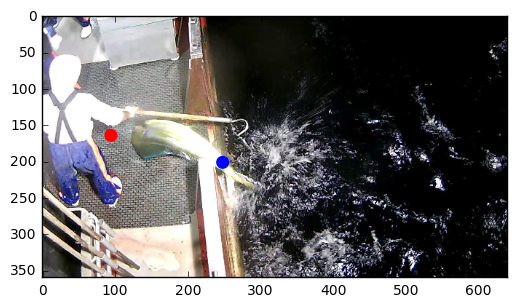

In [118]:

show_bb(num_image)

#### Verifing performance on test data

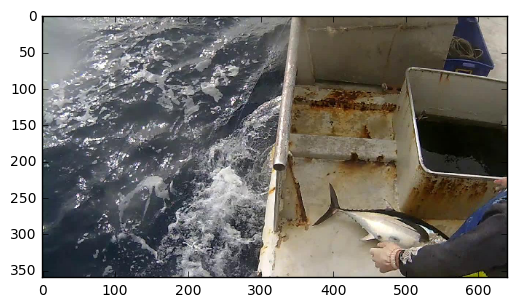

In [286]:
#bad: 489 486 513 580  629
#fantastic:  200 48
#easy: 413 412 195 918

#fixed 999
#got worse 522 200
# 522 fixed after 

# rotation test: 777 646 544
num_image = 399
plt.imshow(to_plot(test[num_image]))


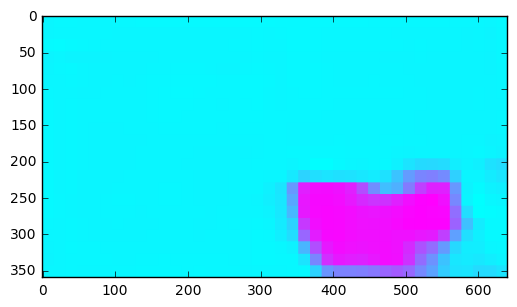

In [287]:
inp = np.expand_dims(conv_test_feat[num_image], 0)
# inp = np.round(model.predict(inp)[0],2)


# cm = get_cm(inp, 0)
conv = conv_fn([inp,0])[0, 0] #conf_fn shape (1, 1, 22, 40)
cm =  scipy.misc.imresize(conv, (360,640), interp='nearest')
plt.imshow(cm, cmap="cool")

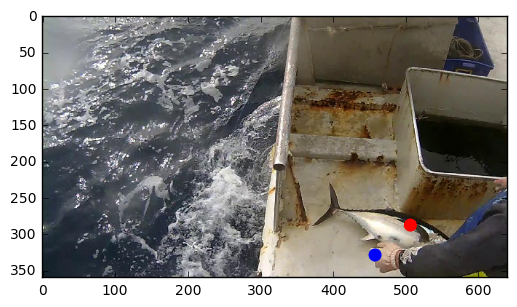

In [288]:
def show_bb(i):
    bb = get_orients(inp)
    plot(test[i])

    plt.gca().add_patch(create_point((bb[0], bb[1])))
    plt.gca().add_patch(create_point((bb[2], bb[3]),"blue"))

show_bb(num_image)

### Crop hotzones

First rotate 

-41.089 48.584 -0.702009877782 -40.2222035173


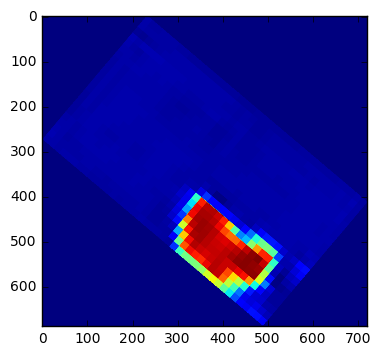

In [289]:
from scipy import ndimage


# def rotateImage(image, center, angle):
#     image_center = center#tuple(np.array(image.shape)/2)
#     rot_mat = cv2.getRotationMatrix2D(image_center,angle,1.0)
#     result = cv2.warpAffine(image, rot_mat, image.shape,flags=cv2.INTER_LINEAR)
#     return result


bb = get_orients(inp)
dy = bb[1]-bb[3]
dx = bb[0]-bb[2]


# signed_degress =math.degrees (math.atan2(dy,dx))
mydegrees = math.degrees(math.atan(dy/dx))
print (dy , dx,math.atan2(dy, dx), mydegrees)

# print (mydegrees,signed_degress)
#rotation angle in degree
cm = ndimage.rotate(cm, mydegrees)
plt.imshow(cm)

Find contours 

In [290]:
ret, thresh = cv2.threshold(cm, 200, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

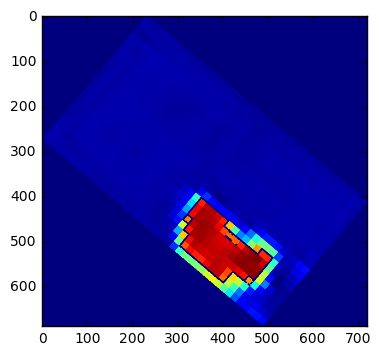

In [291]:
plt.imshow(cv2.drawContours(cm, contours, -1, (0,255,0), 3))


In [18]:
# find a better function than surface. total sum of pixels inside?
def find_biggest_contour(contours):
    
    # nofish? 
    
    
#     if len(contours) == 1 :
#         return 0
    
    #if more than one contour, find the biggest contour surface
    biggest_contour_index = -1 
    biggest_contour_surface = 0

    i = 0
    for c in contours:
        # compute the center of the contour
        area = cv2.contourArea(c)
        if area > biggest_contour_surface:
            biggest_contour_surface = area
            biggest_contour_index = i
        i += 1
        
    return biggest_contour_index        

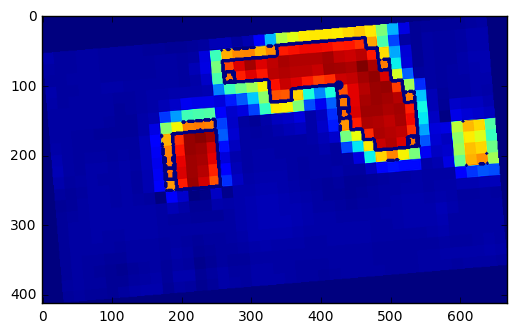

In [277]:

        
#find center of the biggest contour

i = find_biggest_contour(contours)
M = cv2.moments(contours[i])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
    

# draw the contour and center of the shape on the image
cv2.circle(cm, (cX, cY), 7, (0, 0, 0), -1)
plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))


In [278]:
crop_width = 450
width = cm.shape[1]
height = cm.shape[0]

x = max(cX - crop_width/2, 0)
y = max(cY - crop_width/2, 0)
    
if x + crop_width > width:
    x = width - crop_width
if y + crop_width > height:
    y = height - crop_width

x = int(x)
y = int(y)

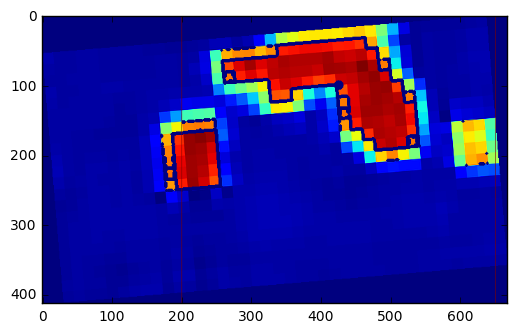

In [279]:
# plt.gca().add_patch(plt.Rectangle((0, 0), 10, 10, color='red', fill=False, lw=2))
cv2.circle(cm, (cX, cY), 7, (0, 0, 0), -1)
cv2.rectangle(cm,(x,y),(x+crop_width,y+crop_width),color=(255, 255, 255))
plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))



### Crop all test data

In [14]:
test_path = DATA_HOME_DIR+"fishnofish/test/test_stg2/"
export_path = DATA_HOME_DIR+'/cropped_nof_excl/test/stg2_mouth_tail_oriented/' # multibox_nopreproc_noaug/'

crop_width = 450


In [12]:
conv_test_feat = load_array(DATA_HOME_DIR+"fishnofish/results/stg2_conv_test_feat_640.dat" )


In [30]:
for i,t in enumerate(raw_test_filenames):
    
#     if i < 1999:
#         continue
    print ("Processing photo ", i+1)

    test_img = cv2.imread(test_path+t)
    img_width = test_img.shape[1]
    img_height = test_img.shape[0]
    
#     plt.imshow(test_img)
    #predict
    
    inp = np.expand_dims(conv_test_feat[i], 0)
    conv = conv_fn([inp,0])[0, 0] #conf_fn shape (1, 1, 22, 40)
    cm = scipy.misc.imresize(conv, (img_height,img_width), interp='nearest')
    
    bb = get_orients(inp)
    dy = bb[1]-bb[3]
    dx = bb[0]-bb[2]
    
    mydegrees = math.degrees(math.atan(dy/dx))
#     print (dy , dx,math.atan2(dy, dx), mydegrees)

    cm = ndimage.rotate(cm, mydegrees)
#     plt.imshow(cm)
    
    
    
    #find contours
    ret, thresh = cv2.threshold(cm, 200, 255, 0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
    #find center of the biggest contour

    i = find_biggest_contour(contours)
    M = cv2.moments(contours[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    
    #calculate boundries of bounding box
    x = max(cX - crop_width/2, 0)
    y = max(cY - crop_width/2, 0)
    
    img_width = cm.shape[1]
    img_height = cm.shape[0]
    
    if x + crop_width > img_width:
        x = img_width - crop_width
    if y + crop_width > img_height:
        y = img_height - crop_width
        
    x = int(x)
    y = int(y)

    
###### plot bounding box    
#     cv2.rectangle(cm,(x,y),(x+crop_width,y+crop_width),color=(255, 255, 255),  thickness= 10)
#     plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))

##### rotate and crop the original image and save
    rotated_image =  ndimage.rotate(test_img, mydegrees)
    crop_img = rotated_image[y:y+crop_width, x:x+crop_width]
#     plt.imshow(crop_img)
    cv2.imwrite(export_path+t,crop_img)
#     break

Processing photo  1
Processing photo  2
Processing photo  3
Processing photo  4
Processing photo  5
Processing photo  6
Processing photo  7
Processing photo  8
Processing photo  9
Processing photo  10
Processing photo  11
Processing photo  12
Processing photo  13
Processing photo  14
Processing photo  15
Processing photo  16
Processing photo  17
Processing photo  18
Processing photo  19
Processing photo  20
Processing photo  21
Processing photo  22
Processing photo  23
Processing photo  24
Processing photo  25
Processing photo  26
Processing photo  27
Processing photo  28
Processing photo  29
Processing photo  30
Processing photo  31
Processing photo  32
Processing photo  33
Processing photo  34
Processing photo  35
Processing photo  36
Processing photo  37
Processing photo  38
Processing photo  39
Processing photo  40
Processing photo  41
Processing photo  42
Processing photo  43
Processing photo  44
Processing photo  45
Processing photo  46
Processing photo  47
Processing photo  48
P